<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/%5Bkareem_202200402%5D_XAI_loan_prediction_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
!pip install pyartemis
# Install required libraries
!pip install kagglehub pandas numpy scikit-learn seaborn matplotlib

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# PDP & ICE
from sklearn.inspection import PartialDependenceDisplay

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


#import data csv

In [ ]:
import pandas as pd
df = pd.read_csv("Final DataFrame.csv")

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Initialize the scaler
scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

In [ ]:
X_exp = X.sample(n=100, random_state=8)
X_exp_scaled = scaler.transform(X_exp)
X_exp_scaled_df = pd.DataFrame(X_exp_scaled, columns=X.columns)

#  RandomForestClassifier – XAI Techniques

| Technique                        | Type              | Why It Works Well |
|----------------------------------|-------------------|--------------------|
| SHAP (TreeExplainer)            | Local & Global    | Efficient and accurate for decision trees, reveals instance-level explanations. |
| Permutation Feature Importance  | Global            | Helps rank features by importance in model performance. |
| Surrogate Tree                  | Global            | Gives a transparent approximation of the random forest logic. |
| Friedman H-Statistic            | Interaction       | Identifies and visualizes where and how features interact. |
| Partial Dependence Plot (PDP)   | Global            | Visualizes average feature effect on predictions. |
| ICE (Individual Conditional Expectation) | Local/Instance-Level | Reveals heterogeneous feature impact across instances. |

#Random forst model


In [ ]:
# pipeline with different classifiers - parameters is from grid search (in another nb for simplicity)
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(max_depth = 10, min_samples_split= 10, n_estimators= 100))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf * 100,"%")


Random Forest Accuracy: 82.72 %


##Model Evaluation


In [ ]:
classification_rep = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      8023
           1       0.83      0.16      0.27      1977

    accuracy                           0.83     10000
   macro avg       0.83      0.58      0.58     10000
weighted avg       0.83      0.83      0.78     10000



In [ ]:
RF_model = pipeline_rf.named_steps['classifier']

## Confusion matrix Random forest

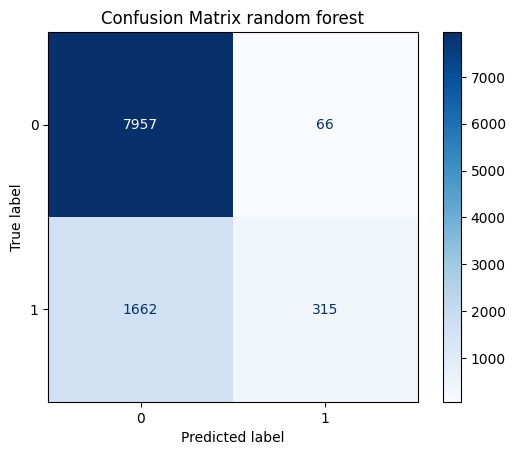

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix random forest')
plt.show()

## Interpretation of Top Features (SHAP)

In [ ]:
# Extract scaler from the pipeline
scaler = pipeline_rf.named_steps['scaler']

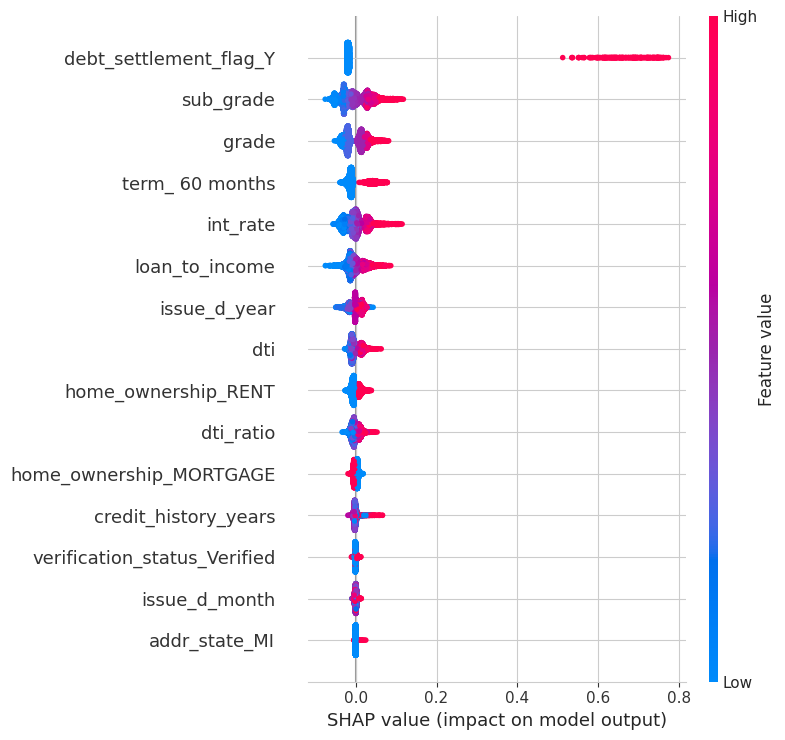

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Get SHAP values from best_model (inside pipeline)
explainer = shap.TreeExplainer(RF_model)
shap_values = explainer.shap_values(X_test)

shap_values = shap_values[:, :, 1]

# Now plot
shap.summary_plot(shap_values, X_test_df)

plt.title("SHAP Summary Plot RF class 1", fontsize=14)
plt.tight_layout()
plt.show()

### Interpretation

- **`debt_settlement_flag_Y`** has the highest influence. If it's `Y`, the model heavily leans toward predicting default.
- **`sub_grade`**, **`grade`**, and **`int_rate`** also play a critical role — higher values push predictions toward default.
- **`loan_to_income`**, **`dti_ratio`**, and **`term_60 months`** have noticeable yet moderate impact.


##Permutation Feature Importance

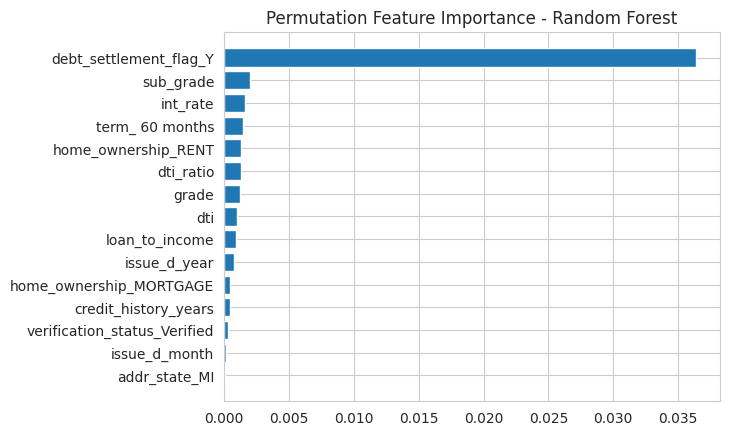

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline_rf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(df.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - Random Forest")
plt.show()

### Interpretation

- **`debt_settlement_flag_Y`** is the most impactful feature — when it's permuted, model performance drops significantly.
- **`sub_grade`** and **`int_rate`** come next, confirming SHAP importance.
- Features like **`term_60 months`** and **`loan_to_income`** have mid-level importance.


##**Global Surrogate Model:**

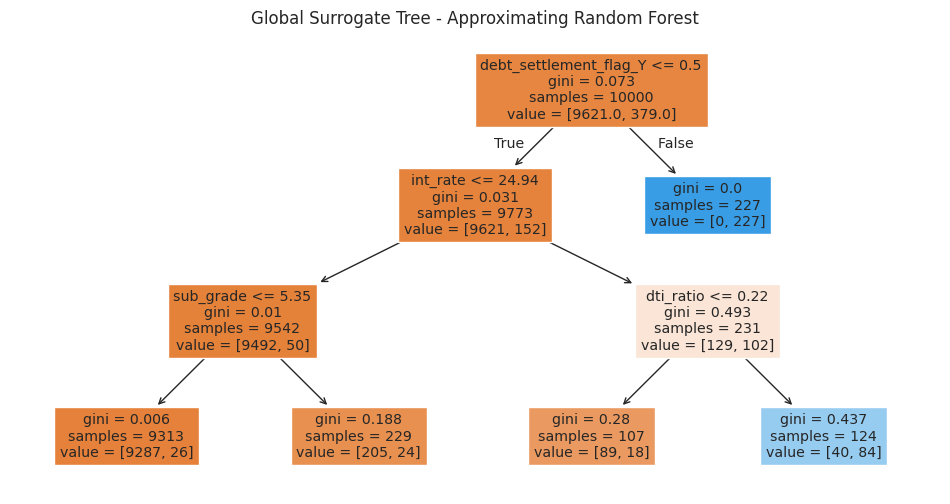

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Train the surrogate on X_test and predictions from black-box model
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(X_test, y_pred_rf)

# Plot the surrogate tree
plt.figure(figsize=(12,6))
tree.plot_tree(surrogate, feature_names=X_test.columns, filled=True)
plt.title("Global Surrogate Tree - Approximating Random Forest")
plt.show()

### Interpretation

- **Root Node**: Splits on `debt_settlement_flag_Y`, confirming it's the strongest signal.
- **Next Nodes**: Include `int_rate`, `sub_grade`, and `dti_ratio`.
- The surrogate offers a simple, human-readable summary of how the complex model behaves in most cases.

##**H-Statistic (Feature Interaction):**

The H-statistic defines the interaction between features as the share of variance that is explained by the interaction.


In [ ]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [ ]:
X_exp = X.sample(n=100, random_state=8)
X_exp_scaled = scaler.transform(X_exp)
X_exp_scaled_df = pd.DataFrame(X_exp_scaled, columns=X.columns)

# Fit Friedman H statistic evaluator
h_stat = FriedmanHStatisticMethod()
h_stat.fit(pipeline_rf, X_exp_scaled_df)

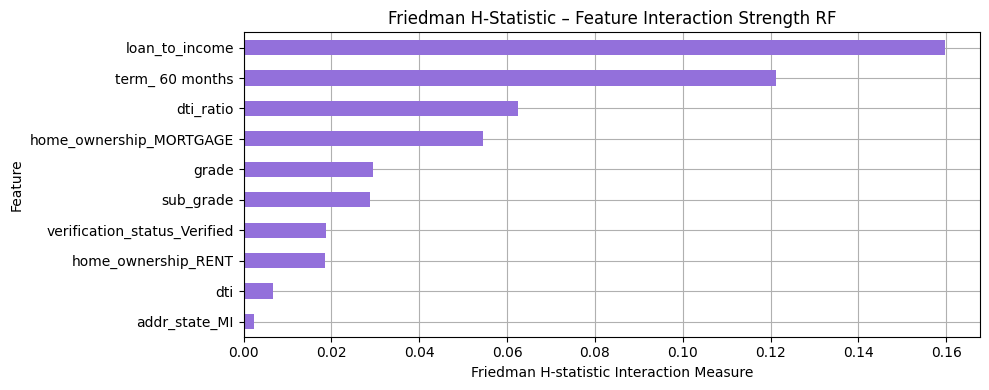

In [ ]:
# Overall interaction plot
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

ax.set_title("Friedman H-Statistic – Feature Interaction Strength RF")
plt.tight_layout()
plt.show()

### Interpretation

- **`loan_to_income`** shows the strongest interactions — its effect depends on other feature contexts.
- **`home_ownership_RENT`**, **`term_60 months`**, and **`dti_ratio`** are also moderately interacting.
- The produced findings expose **nonlinear feature dependencies**  between features and display the areas where interactions reach their most significant points.


##  Partial Dependence Plot (PDP)

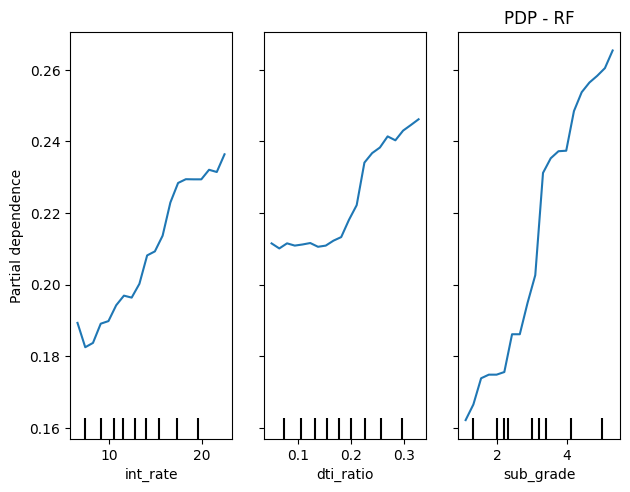

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = ['debt_settlement_flag_Y', 'sub_grade', 'int_rate']

PartialDependenceDisplay.from_estimator(
    pipeline_rf,
    X_test,
    features=['int_rate', 'dti_ratio','sub_grade'],
    grid_resolution=20
)
plt.tight_layout()
plt.title("PDP - RF")
plt.show()

### Interpretation

- **`int_rate`**: Higher rates significantly increase default risk.
- **`dti_ratio`**: A critical threshold around 0.2 exists — risk spikes above that.
- **`sub_grade`**: Lower grades (e.g., F/G) are associated with a steep increase in default probability.
- PDPs show the **average marginal effect** of each feature on the predicted outcome while keeping others constant.
